In [4]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
#import xarray as xr
import pandas as pd
import joblib
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, median_absolute_error

In [6]:
from scipy.stats import randint
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [7]:
# shape library
import shap

In [8]:
# print the JS visualization code to the notebook
shap.initjs()

In [60]:
os.getcwd()

'/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/Modeling'

In [61]:
train_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/train.csv')
test_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/test.csv')

In [64]:
def per_pop(population, feature):
    if population > 0:
        return 1000 * feature/population
    else:
        return np.nan

In [65]:
train_df['EVICTIONS'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['EVICTIONS']), axis=1)
train_df['AFAM'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
train_df['WHITE'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
train_df['HISPANIC'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [66]:
train_df.describe()

EP_UNEMP         EP_PCI        EP_POV      EP_NOVEH     EP_NOHSDP  \
count  11892.000000   11907.000000  11884.000000  11878.000000  11911.000000   
mean       7.951892   28557.180986     16.459635      9.359151     12.745294   
std        5.538075   13485.964541     12.734019     11.922755      9.427160   
min        0.000000     238.000000      0.000000      0.000000      0.000000   
25%        4.300000   19966.000000      7.200000      2.500000      5.700000   
50%        6.500000   25738.000000     13.100000      5.400000     10.400000   
75%       10.000000   33788.000000     22.200000     11.000000     17.600000   
max       59.300000  140255.000000    100.000000    100.000000     66.900000   

          EP_MOBILE     EP_MINRTY      EP_CROWD      EP_AGE65      EP_AGE17  \
count  11881.000000  11989.000000  11989.000000  11912.000000  11989.000000   
mean       6.583116     32.903637      2.497798     15.466429     22.105030   
std       11.411780     27.998938      3.490491      7.688546      6.699485   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      9.700000      0.400000     10.500000     18.700000   
50%        0.800000     23.900000      1.400000     14.900000     22.400000   
75%        8.300000     50.200000      3.300000     19.000000     26.000000   
max      100.000000    100.000000    100.000000    100.000000     53.600000   

               AFAM         WHITE      HISPANIC    WFIR_AFREQ    HRCN_AFREQ  \
count  11913.000000  11913.000000  11913.000000  11970.000000  10340.000000   
mean       3.627453     33.783063      3.090173      0.000300      0.093429   
std        5.942572     23.885437      4.994945      0.001233      0.093278   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.275786     17.846154      0.441989      0.000003      0.011968   
50%        1.260769     31.826862      1.346257      0.000023      0.065002   
75%        4.480287     45.717036      3.629764      0.000134      0.161570   
max       99.833611    500.000000    131.355932      0.048083      0.443213   

        CFLD_AFREQ    RFLD_AFREQ    HWAV_AFREQ    POPULATION     EVICTIONS  
count  5522.000000  11970.000000  11970.000000  12023.000000  11913.000000  
mean      1.028563      1.850286      0.882896   4261.110538      5.517092  
std       1.634605      1.960736      1.399491   2167.705352      7.761011  
min       0.000000      0.000000      0.000000      0.000000      0.000000  
25%       0.000000      0.583333      0.082372   2852.000000      0.945716  
50%       0.002000      1.458333      0.411862   4001.000000      2.552467  
75%       2.049602      2.458333      0.988468   5346.500000      6.682578  
max       4.512000     12.666670      8.731466  53812.000000     99.357602

In [67]:
test_df['EVICTIONS'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['EVICTIONS']), axis=1)
test_df['AFAM'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
test_df['WHITE'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
test_df['HISPANIC'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [68]:
test_df.describe()

EP_UNEMP         EP_PCI       EP_POV     EP_NOVEH    EP_NOHSDP  \
count  2973.000000    2976.000000  2972.000000  2971.000000  2977.000000   
mean      8.067037   28391.974126    16.993102     9.880781    12.979342   
std       5.533451   13515.934969    12.935581    12.950432     9.808189   
min       0.000000       6.000000     0.000000     0.000000     0.000000   
25%       4.400000   19736.250000     7.300000     2.650000     5.700000   
50%       6.600000   25543.500000    13.600000     5.500000    10.500000   
75%      10.000000   33482.250000    23.425000    11.450000    18.000000   
max      43.800000  139678.000000   100.000000   100.000000   100.000000   

         EP_MOBILE    EP_MINRTY     EP_CROWD     EP_AGE65     EP_AGE17  \
count  2972.000000  2996.000000  2996.000000  2977.000000  2996.000000   
mean      6.413190    33.215454     2.549599    15.430131    22.030207   
std      11.392921    28.191928     3.892751     7.983248     6.838481   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    10.100000     0.400000    10.500000    18.600000   
50%       0.700000    23.700000     1.400000    14.700000    22.400000   
75%       8.100000    50.575000     3.200000    18.900000    26.000000   
max     100.000000   100.000000   100.000000   100.000000    53.900000   

              AFAM        WHITE     HISPANIC   WFIR_AFREQ   HRCN_AFREQ  \
count  2978.000000  2978.000000  2978.000000  2993.000000  2577.000000   
mean      3.493328    33.206830     2.923151     0.000293     0.092543   
std       5.712945    24.774926     4.993474     0.001192     0.094678   
min       0.000000     0.000000     0.000000     0.000000     0.005361   
25%       0.282107    16.944886     0.443361     0.000003     0.011968   
50%       1.228937    30.951420     1.263959     0.000021     0.059841   
75%       4.228331    44.947875     3.409286     0.000132     0.161570   
max      78.617927   380.681818   111.111111     0.035338     0.430854   

        CFLD_AFREQ   RFLD_AFREQ   HWAV_AFREQ    POPULATION    EVICTIONS  
count  1394.000000  2994.000000  2994.000000   3008.000000  2978.000000  
mean      1.006092     1.830122     0.938766   4293.026596     5.890666  
std       1.637243     1.921024     1.450644   2103.466846    12.694082  
min       0.000000     0.000000     0.000000      0.000000     0.000000  
25%       0.000000     0.541667     0.164745   2859.500000     0.971817  
50%       0.002000     1.458333     0.494234   4066.000000     2.699056  
75%       2.037666     2.458333     0.988468   5432.000000     6.865161  
max       4.512000    12.666670     8.731466  28926.000000   529.411765

In [69]:
XY_var = list(train_df.columns)
XY_var.pop(0)
XY_var

['EP_UNEMP',
 'EP_PCI',
 'EP_POV',
 'EP_NOVEH',
 'EP_NOHSDP',
 'EP_MOBILE',
 'EP_MINRTY',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ',
 'POPULATION',
 'EVICTIONS']

In [70]:
corr_train = train_df[XY_var].corr()
corr_train_df = pd.DataFrame(corr_train, index=XY_var, columns=XY_var)

<Axes:title={'center':'Training data corrrelation'}>

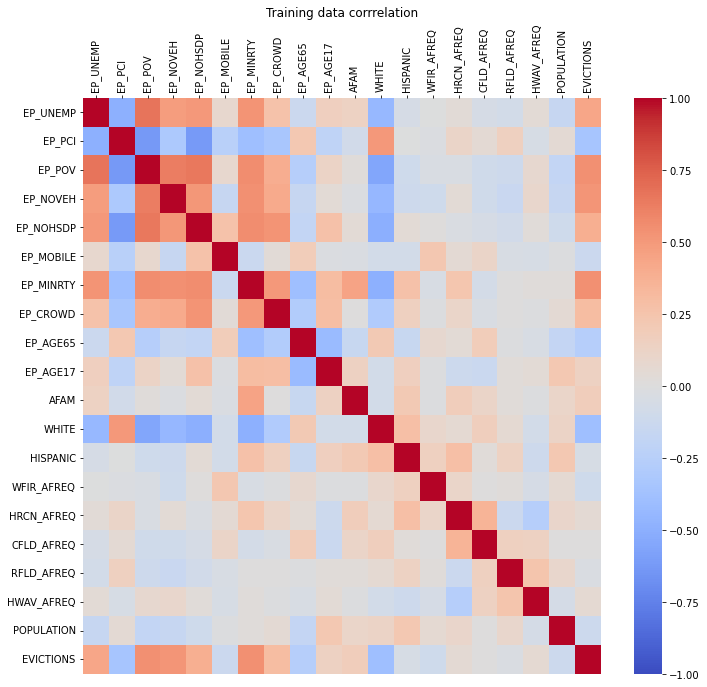

In [71]:
fig = plt.figure(figsize = (9,8))
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_ticks_position("top")
plt.title("Training data corrrelation")
sns.heatmap(corr_train_df, center = 0, vmin=-1, vmax=1, cmap = 'coolwarm')

In [72]:
corr_train

EP_UNEMP    EP_PCI    EP_POV  EP_NOVEH  EP_NOHSDP  EP_MOBILE  \
EP_UNEMP    1.000000 -0.494504  0.667656  0.480295   0.505420   0.081013   
EP_PCI     -0.494504  1.000000 -0.627638 -0.315351  -0.624941  -0.242241   
EP_POV      0.667656 -0.627638  1.000000  0.625888   0.650145   0.081327   
EP_NOVEH    0.480295 -0.315351  0.625888  1.000000   0.509378  -0.157552   
EP_NOHSDP   0.505420 -0.624941  0.650145  0.509378   1.000000   0.258484   
EP_MOBILE   0.081013 -0.242241  0.081327 -0.157552   0.258484   1.000000   
EP_MINRTY   0.523932 -0.395673  0.557239  0.545769   0.561454  -0.135218   
EP_CROWD    0.260525 -0.339120  0.391731  0.412020   0.530635   0.031791   
EP_AGE65   -0.131219  0.226022 -0.261701 -0.157763  -0.185375   0.184242   
EP_AGE17    0.158638 -0.204797  0.123653  0.041187   0.268560  -0.019484   
AFAM        0.137845 -0.091611  0.022880 -0.018980   0.044132  -0.029871   
WHITE      -0.442633  0.502674 -0.558273 -0.449826  -0.505274  -0.080464   
HISPANIC   -0.060405 -0.003104 -0.103589 -0.114913   0.044502  -0.080243   
WFIR_AFREQ -0.007802 -0.023061 -0.031918 -0.103168   0.014053   0.230295   
HRCN_AFREQ  0.038120  0.113074 -0.033659  0.046226  -0.025519   0.049931   
CFLD_AFREQ -0.056012  0.054050 -0.096322 -0.095743  -0.054705   0.110151   
RFLD_AFREQ -0.082464  0.153281 -0.112155 -0.147296  -0.092834  -0.045591   
HWAV_AFREQ  0.043835 -0.053258  0.071541  0.091013   0.027118  -0.050702   
POPULATION -0.159476  0.053508 -0.187447 -0.163215  -0.107469  -0.009269   
EVICTIONS   0.436363 -0.348056  0.539311  0.521911   0.390142  -0.125341   

            EP_MINRTY  EP_CROWD  EP_AGE65  EP_AGE17      AFAM     WHITE  \
EP_UNEMP     0.523932  0.260525 -0.131219  0.158638  0.137845 -0.442633   
EP_PCI      -0.395673 -0.339120  0.226022 -0.204797 -0.091611  0.502674   
EP_POV       0.557239  0.391731 -0.261701  0.123653  0.022880 -0.558273   
EP_NOVEH     0.545769  0.412020 -0.157763  0.041187 -0.018980 -0.449826   
EP_NOHSDP    0.561454  0.530635 -0.185375  0.268560  0.044132 -0.505274   
EP_MOBILE   -0.135218  0.031791  0.184242 -0.019484 -0.029871 -0.080464   
EP_MINRTY    1.000000  0.500723 -0.393476  0.300892  0.448679 -0.495516   
EP_CROWD     0.500723  1.000000 -0.284238  0.292757  0.002116 -0.295063   
EP_AGE65    -0.393476 -0.284238  1.000000 -0.423751 -0.150188  0.217097   
EP_AGE17     0.300892  0.292757 -0.423751  1.000000  0.146463 -0.084231   
AFAM         0.448679  0.002116 -0.150188  0.146463  1.000000 -0.079873   
WHITE       -0.495516 -0.295063  0.217097 -0.084231 -0.079873  1.000000   
HISPANIC     0.271573  0.151971 -0.150216  0.159874  0.214894  0.282341   
WFIR_AFREQ  -0.046169 -0.009739  0.074157 -0.008671 -0.015409  0.087494   
HRCN_AFREQ   0.235594  0.102497  0.040198 -0.118523  0.178778  0.059448   
CFLD_AFREQ  -0.077628 -0.031708  0.180654 -0.139132  0.114516  0.169694   
RFLD_AFREQ   0.007396  0.002890 -0.012107  0.026828  0.025014  0.062424   
HWAV_AFREQ   0.020745 -0.008243 -0.043878  0.040827 -0.008216 -0.082834   
POPULATION   0.016362  0.048259 -0.176225  0.225465  0.108224  0.119429   
EVICTIONS    0.545172  0.298167 -0.260023  0.144340  0.174300 -0.391413   

            HISPANIC  WFIR_AFREQ  HRCN_AFREQ  CFLD_AFREQ  RFLD_AFREQ  \
EP_UNEMP   -0.060405   -0.007802    0.038120   -0.056012   -0.082464   
EP_PCI     -0.003104   -0.023061    0.113074    0.054050    0.153281   
EP_POV     -0.103589   -0.031918   -0.033659   -0.096322   -0.112155   
EP_NOVEH   -0.114913   -0.103168    0.046226   -0.095743   -0.147296   
EP_NOHSDP   0.044502    0.014053   -0.025519   -0.054705   -0.092834   
EP_MOBILE  -0.080243    0.230295    0.049931    0.110151   -0.045591   
EP_MINRTY   0.271573   -0.046169    0.235594   -0.077628    0.007396   
EP_CROWD    0.151971   -0.009739    0.102497   -0.031708    0.002890   
EP_AGE65   -0.150216    0.074157    0.040198    0.180654   -0.012107   
EP_AGE17    0.159874   -0.008671   -0.118523   -0.139132    0.026828   
AFAM        0.214894   -0.015409    0.178778   

### Examine multicollinearity between features using Variance Inflation Factor

In [73]:
X_var = copy.deepcopy(XY_var)
X_var.remove('EVICTIONS')
X_var.remove('POPULATION')
temp = train_df[X_var]
sel = ~temp.isna().any(axis=1)
temp = temp.loc[sel,]
temp_cols = pd.Index(['const'])
temp_cols = temp_cols.append(temp.columns)

In [74]:
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1]+1)], 
              index=temp_cols).sort_values(ascending=False)
vifs

const         54.274716
EP_MINRTY      5.748367
EP_POV         3.815474
EP_NOHSDP      3.468006
EP_NOVEH       3.041253
WHITE          2.684534
EP_PCI         2.452304
EP_UNEMP       2.240264
EP_CROWD       1.877264
AFAM           1.670352
EP_AGE65       1.635415
EP_AGE17       1.608447
HISPANIC       1.568768
HRCN_AFREQ     1.520386
RFLD_AFREQ     1.452642
EP_MOBILE      1.440626
HWAV_AFREQ     1.396111
CFLD_AFREQ     1.302713
WFIR_AFREQ     1.123669
dtype: float64

In [75]:
X_var = ['EP_UNEMP',
 'EP_PCI',
 'EP_NOVEH',
 'EP_MOBILE',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ'
]
temp = train_df[X_var]
sel = ~temp.isna().any(axis=1)
temp = temp.loc[sel,]
temp_cols = pd.Index(['const'])
temp_cols = temp_cols.append(temp.columns)

In [76]:
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1]+1)], 
              index=temp_cols).sort_values(ascending=False)
vifs

const         44.929572
EP_NOVEH       2.199315
WHITE          2.048691
EP_PCI         1.962866
EP_UNEMP       1.776803
EP_CROWD       1.723336
EP_AGE65       1.559881
EP_AGE17       1.499917
HRCN_AFREQ     1.454215
RFLD_AFREQ     1.448442
HWAV_AFREQ     1.384048
HISPANIC       1.309997
EP_MOBILE      1.298389
CFLD_AFREQ     1.297645
AFAM           1.206151
WFIR_AFREQ     1.122971
dtype: float64

### Final feature selection and data prep

In [77]:
X_var = ['EP_UNEMP',
 'EP_PCI',
 'EP_NOVEH',
 'EP_MOBILE',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ']
Y_var = ['EVICTIONS']

In [78]:
#train_sel = ~train_df[X_var+Y_var].isna().any(axis=1)
train_sel = ~train_df[Y_var].isna().any(axis=1)
sum(train_sel)

11913

In [79]:
#X_train = train_df.loc[train_sel,X_var].to_numpy()
y_train = train_df.loc[train_sel,Y_var].to_numpy().ravel()
X_train = train_df.loc[train_sel,X_var]
#y_train = train_df.loc[train_sel,Y_var]

In [80]:
#test_sel = ~test_df[X_var+Y_var].isna().any(axis=1)
test_sel = ~test_df[Y_var].isna().any(axis=1)
sum(test_sel)

2978

In [81]:
#X_test = test_df.loc[test_sel,X_var].to_numpy()
y_test = test_df.loc[test_sel,Y_var].to_numpy().ravel()
X_test = test_df.loc[test_sel,X_var]
#y_test = test_df.loc[test_sel,Y_var]

## HistGBoost (Poisson) Model Specification

In [26]:
# Parameter grids
hgbr_param_grid = {"max_iter":[100, 250, 500, 1000], 
                   "max_depth":[3,4,5,6],   
                }

In [29]:
# Parameters for random search
hgbr_rand_grid = {"max_iter":randint(100,5000), 
                  "max_depth":randint(2,10),
                  "learning_rate":[0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
                  "max_leaf_nodes":[15, 31, 63, 127],
                  "min_samples_leaf":[10, 20, 30, 40, 50]
                }

In [30]:
kf = KFold(n_splits=5).split(X_train,y_train)
hgbr_model = HistGradientBoostingRegressor(loss="poisson", early_stopping=True, random_state=123)
#grid = GridSearchCV(hgbr_model, hgbr_param_grid, scoring='neg_mean_squared_error', cv=kf, return_train_score=False, refit=True)
rand_grid = RandomizedSearchCV(hgbr_model, hgbr_rand_grid, n_iter=100, scoring='neg_mean_absolute_error', cv=kf, return_train_score=False, refit=True)

In [32]:
print(datetime.datetime.now())

rand_grid.fit(X_train,y_train)
best_params = rand_grid.best_params_
print(best_params)

print(datetime.datetime.now())

2021-12-05 19:05:10.483466
{'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 3945, 'max_leaf_nodes': 63, 'min_samples_leaf': 20}
2021-12-05 19:56:31.651730


In [34]:
print(rand_grid.best_score_)

-0.2673547856531483


In [82]:
best_params

{'learning_rate': 0.01,
 'max_depth': 7,
 'max_iter': 3945,
 'max_leaf_nodes': 63,
 'min_samples_leaf': 20}

In [83]:
# Fit the model on train data using optimal hyperparameters 
hgbr_model = HistGradientBoostingRegressor(loss="poisson", random_state=123, **best_params)
hgbr_model.fit(X_train, y_train)

HistGradientBoostingRegressor(learning_rate=0.01, loss='poisson', max_depth=7,
                              max_iter=3945, max_leaf_nodes=63,
                              random_state=123)

In [125]:
def write_pkl(file_name, model):
    with open(file_name, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [126]:
file_name = '/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/Modeling/Models/PoissGBoost_Base.pickle'
write_pkl(file_name,hgbr_model)

##  HistGBoost (Poisson) Model Evaluation

In [36]:
def evaluate_predict(y, pred):
    scores = {
        'mse':mean_squared_error(y, pred),
        'rmse':np.sqrt(mean_squared_error(y, pred)),
        'mae':mean_absolute_error(y, pred),
        'medae':median_absolute_error(y, pred),
        'max_error':max_error(y, pred),
        'bias':pred.mean() - y.mean(),
        'r2':r2_score(y, pred),
        'corr':np.corrcoef(y,pred)[0,1],
        }
    return scores

### Train data metrics

In [84]:
# Calculate test data error metrics
y_pred_train = hgbr_model.predict(X_train)

resid_train = y_train - y_pred_train
df_results_train = pd.DataFrame({'y_train':y_train, 'y_pred_train': y_pred_train, 'resid_train': resid_train})

In [85]:
train_scores = evaluate_predict(y_train, y_pred_train)
train_scores

{'mse': 7.955485618989601,
 'rmse': 2.8205470425060457,
 'mae': 1.7191850832087683,
 'medae': 0.989787216323673,
 'max_error': 36.89547774605563,
 'bias': -0.027788972789826616,
 'r2': 0.8679110421607825,
 'corr': 0.9348156020730867}

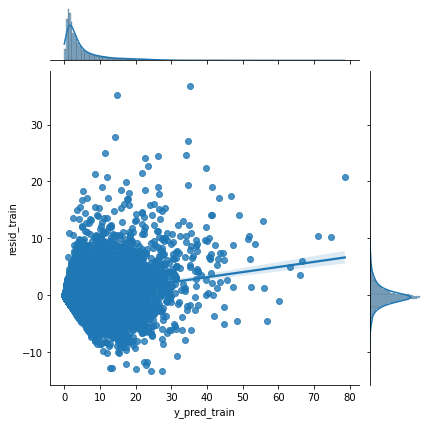

In [86]:
sns.jointplot(x = 'y_pred_train', y = 'resid_train', data = df_results_train, kind = 'reg')

### Test data metrics

In [90]:
X_test_out = X_test[y_test<100]
y_test_out = y_test[y_test<100]

In [91]:
# Calculate test data error metrics
y_pred_test = hgbr_model.predict(X_test_out)

resid_test = y_test_out - y_pred_test
df_results = pd.DataFrame({'y_test':y_test_out, 'y_pred_test': y_pred_test, 'resid_test': resid_test})

In [92]:
test_scores = evaluate_predict(y_test_out, y_pred_test)
test_scores

{'mse': 23.194951711276815,
 'rmse': 4.8161137560565175,
 'mae': 2.6447730022192353,
 'medae': 1.3103440138607507,
 'max_error': 64.75728581161945,
 'bias': -0.17289622032546603,
 'r2': 0.6240218764829286,
 'corr': 0.7904426418736598}

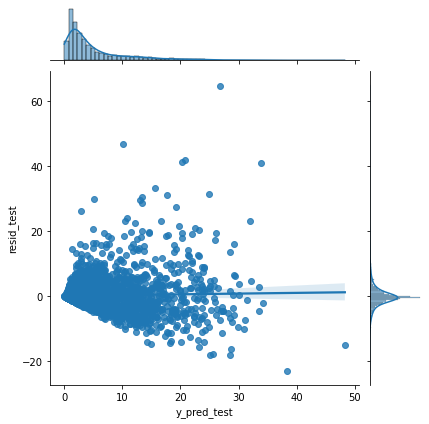

In [93]:
sns.jointplot(x = 'y_pred_test', y = 'resid_test', data = df_results, kind = 'reg')

[Text(0.5, 0, 'y_test predicted'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Histogram of y_test predicted'),
 (0.0, 1500.0)]

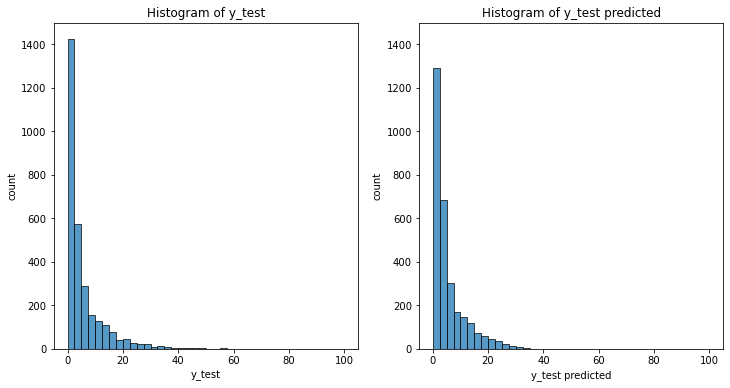

In [95]:
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
sns.histplot(y_pred_test, kde=False,  binwidth = 2.5, binrange = (0,100), ax = ax[1])
sns.histplot(y_test, kde=False, binwidth = 2.5, binrange = (0,100), ax = ax[0])

ax[0].set(xlabel='y_test', ylabel='count', title='Histogram of y_test', ylim=[0,1500])
ax[1].set(xlabel='y_test predicted', ylabel='count', title='Histogram of y_test predicted', ylim=[0,1500])

<Axes:ylabel='Count'>

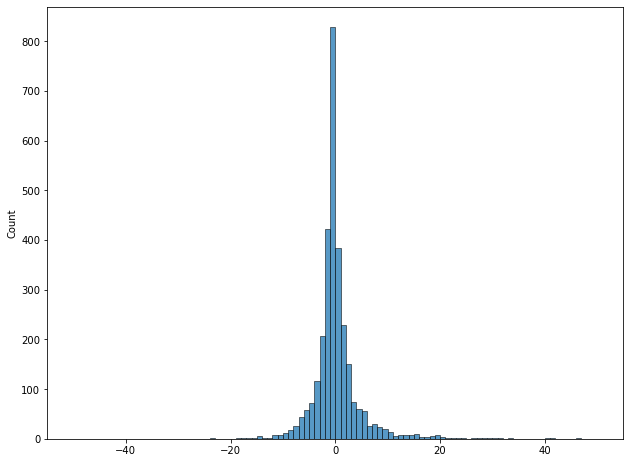

In [99]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_axes([0,0,1,1])
sns.histplot(resid_test, kde=False, binwidth = 1, binrange = (-50,50))

In [96]:
np.std(resid_test)

4.813009308974374

## Feature importance with SHAP

In [101]:
# explain the model's predictions using SHAP
t_explainer = shap.TreeExplainer(hgbr_model)
t_shap_values = t_explainer(X_test)
shap_values = t_explainer.shap_values(X_test)

In [104]:
t_shap_values

.values =
array([[ 0.05849404, -0.11936462, -0.06739779, ...,  0.02297762,
        -0.00817743, -0.20343188],
       [-0.0056896 ,  0.16361725, -0.4207162 , ..., -0.01856265,
         0.01347722,  0.01071279],
       [ 0.04722623,  0.10337587,  0.2191872 , ..., -0.02931784,
         0.01215214,  0.00507339],
       ...,
       [ 0.23071738, -0.00516614, -0.41556771, ...,  0.02012571,
        -0.07281332,  0.05771132],
       [-0.17406556,  0.05295645, -0.30897243, ...,  0.04356234,
        -0.0473858 ,  0.14096552],
       [-0.27219334,  0.07093723, -0.5394386 , ...,  0.03204107,
        -0.07249635,  0.09906696]])

.base_values =
array([[1.15002125],
       [1.15002125],
       [1.15002125],
       ...,
       [1.15002125],
       [1.15002125],
       [1.15002125]])

.data =
array([[8.10000000e+00, 3.41050000e+04, 5.80000000e+00, ...,
                   nan, 1.08333333e+00, 4.11861614e-01],
       [5.60000000e+00, 2.73750000e+04, 2.20000000e+00, ...,
        2.06558614e+00, 2.70833333

In [106]:
shap_values

array([[ 0.05849404, -0.11936462, -0.06739779, ...,  0.02297762,
        -0.00817743, -0.20343188],
       [-0.0056896 ,  0.16361725, -0.4207162 , ..., -0.01856265,
         0.01347722,  0.01071279],
       [ 0.04722623,  0.10337587,  0.2191872 , ..., -0.02931784,
         0.01215214,  0.00507339],
       ...,
       [ 0.23071738, -0.00516614, -0.41556771, ...,  0.02012571,
        -0.07281332,  0.05771132],
       [-0.17406556,  0.05295645, -0.30897243, ...,  0.04356234,
        -0.0473858 ,  0.14096552],
       [-0.27219334,  0.07093723, -0.5394386 , ...,  0.03204107,
        -0.07249635,  0.09906696]])

In [235]:
# visualize all the training set predictions
#shap.plots.force(t_shap_values)
shap.force_plot(t_explainer.expected_value, shap_values, X_var)

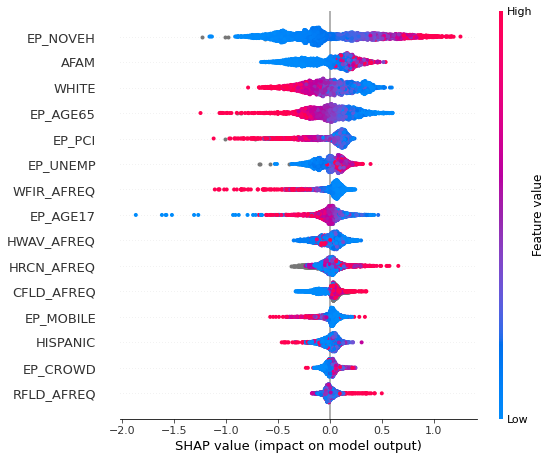

In [107]:
#shap.plots.beeswarm(t_shap_values, max_display=20)
shap.summary_plot(t_shap_values, X_test)

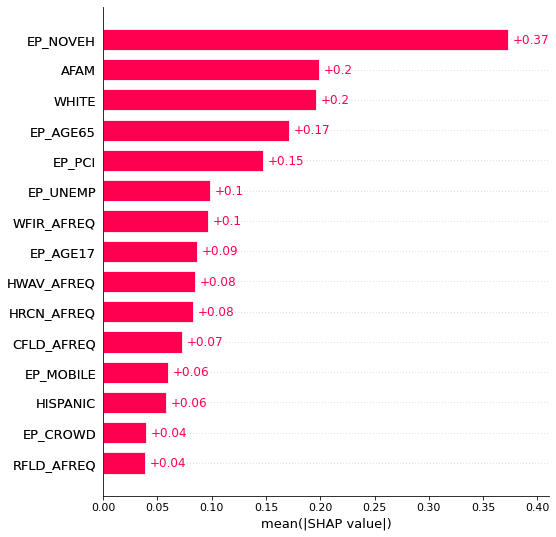

In [108]:
shap.plots.bar(t_shap_values, max_display=20)

### Dependence Plot: No Vehicles and Climate Disasters

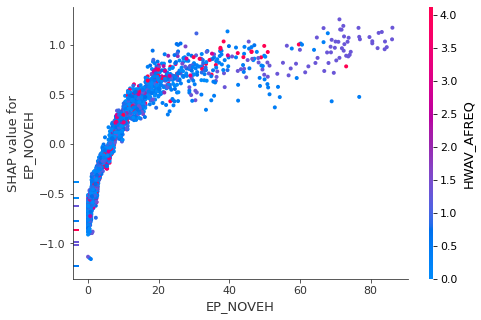

In [109]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HWAV_AFREQ")

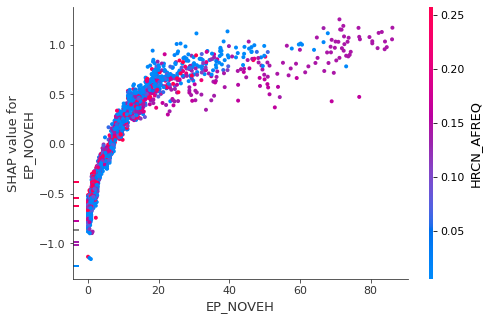

In [110]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HRCN_AFREQ")

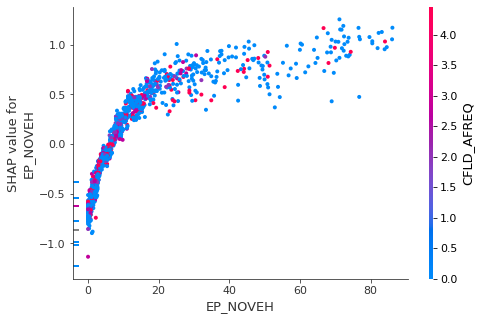

In [111]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="CFLD_AFREQ")

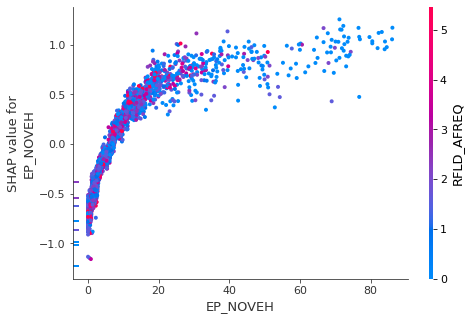

In [112]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="RFLD_AFREQ")

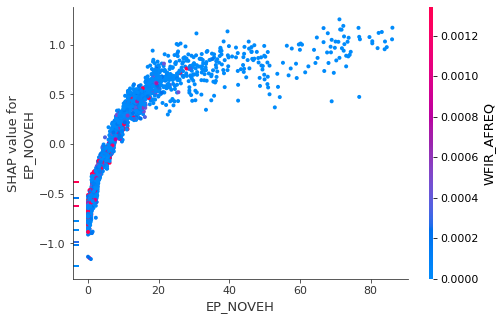

In [113]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: African-American (Mortgage Applicants) and Climate Disasters

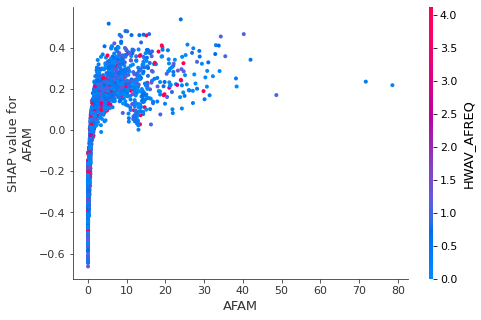

In [114]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HWAV_AFREQ")

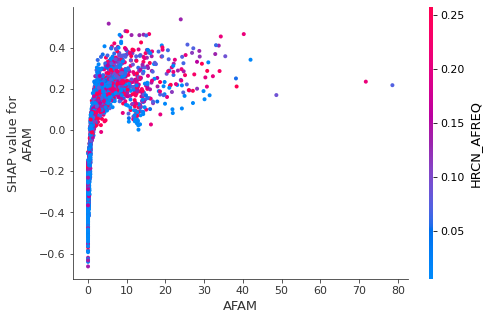

In [115]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HRCN_AFREQ")

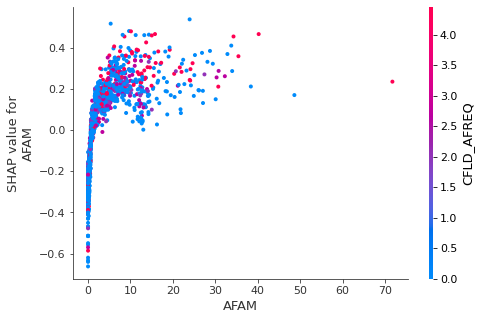

In [116]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="CFLD_AFREQ")

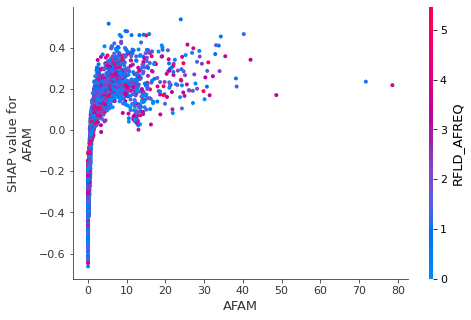

In [117]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="RFLD_AFREQ")

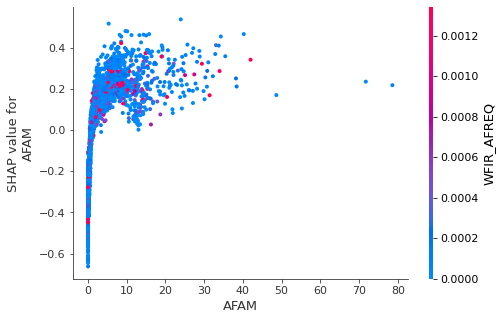

In [118]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: White (Mortgage Applicants) and Climate Disasters

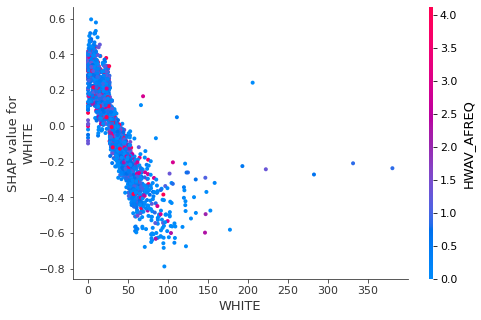

In [119]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HWAV_AFREQ")

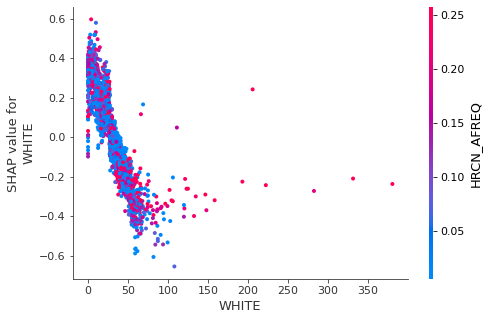

In [120]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HRCN_AFREQ")

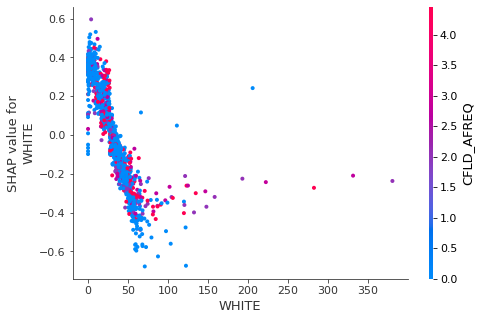

In [121]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="CFLD_AFREQ")

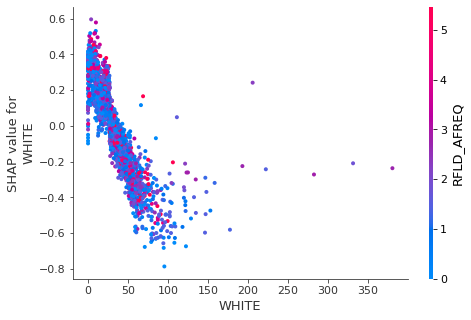

In [122]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="RFLD_AFREQ")

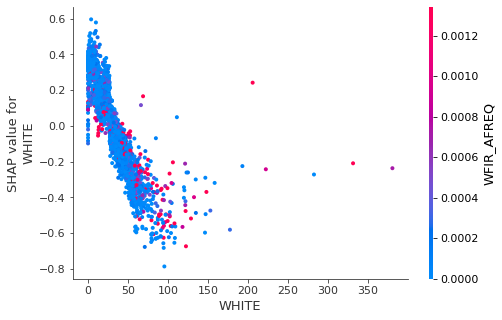

In [123]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: Top Interaction for Each Feature

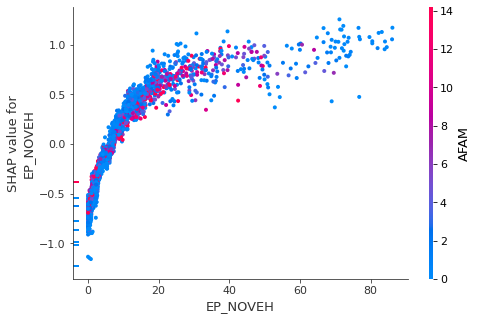

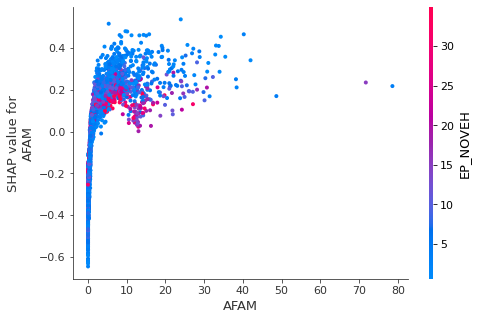

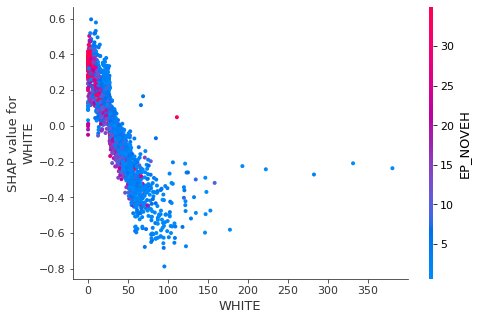

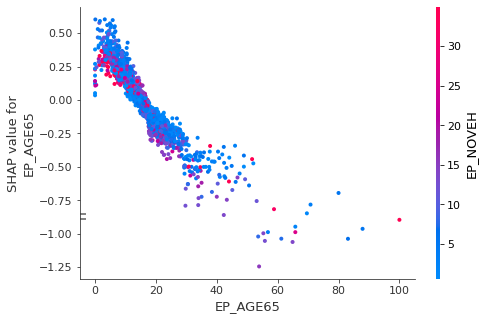

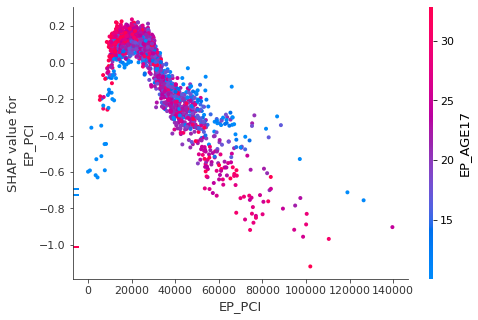

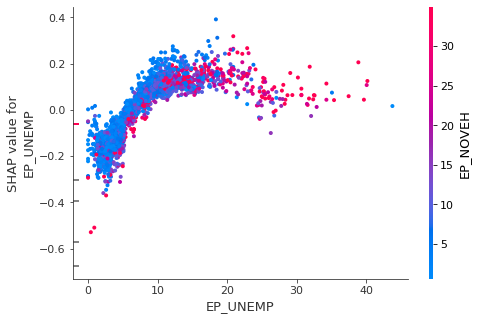

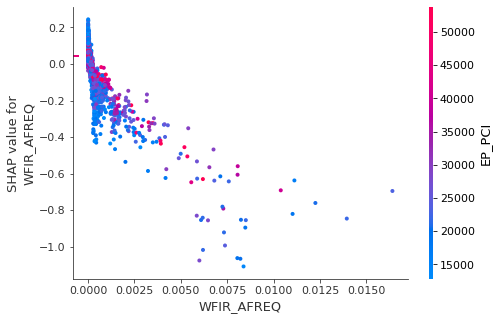

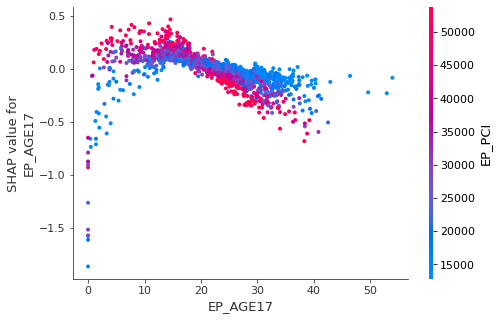

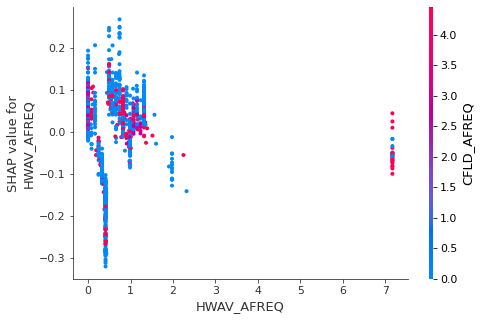

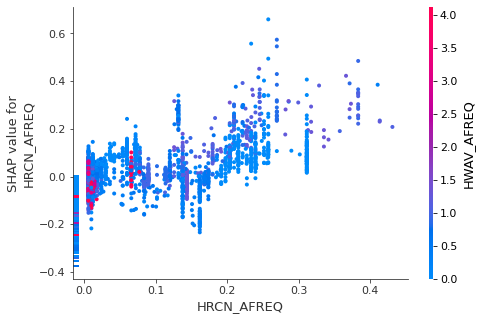

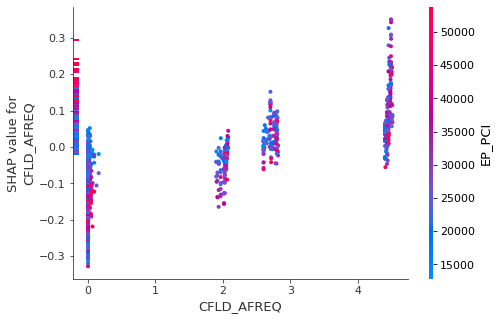

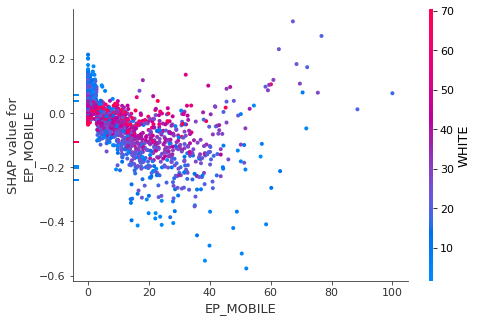

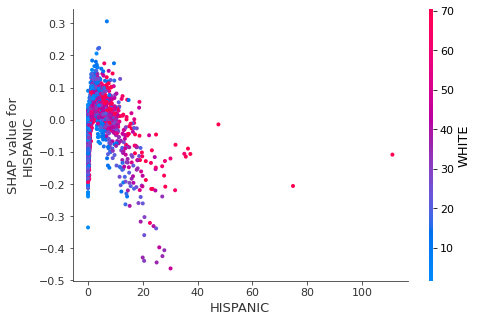

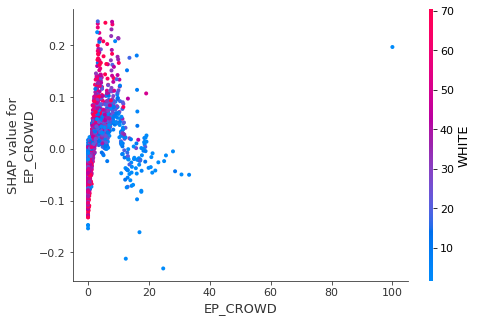

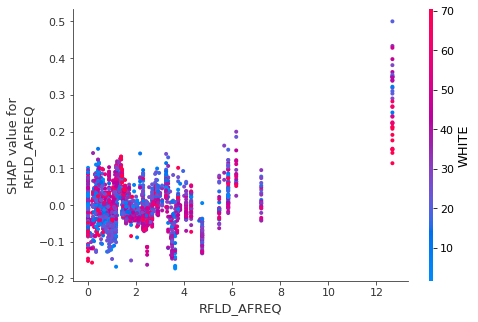

In [124]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(X_test.shape[1]):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

## Prepare a Data Frame with predictions and SHAP values

In [81]:
test_results_df = pd.DataFrame({'FIPS': test_df.loc[test_sel,'FIPS'], 'EVICTIONS': y_test, 'EVICTIONS_PREDICTED': y_pred_test})

In [82]:
test_results_df

FIPS  EVICTIONS  EVICTIONS_PREDICTED
0     01001020801GID   0.031377             0.186219
1     01003010705GID   0.436031             0.294574
2     01003010903GID   0.206540             0.428928
3     01003011000GID   0.262217             0.344457
4     01003011101GID   0.108460             0.166042
...              ...        ...                  ...
3003  55141010500GID   0.092109             0.231161
3004  55141010900GID   0.049554             0.101107
3005  55141011600GID   0.216365             0.091578
3006  56017967800GID   0.071098             0.077214
3007  56035000101GID   0.000000             0.044958

[2978 rows x 3 columns]